# Анализ объявлений по продаже недвижимости с cian.ru

**Подключаем библиотеки**

In [285]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from statsmodels.stats.weightstats import ztest as ztest

**Подключаем базу данных**

In [286]:
df = pd.read_csv('Cian.csv', sep=',')
df

,Unnamed: 0,Ссылка,Комнаты,Цена,Цена за метр,Метро,Время до метро(мин),Площадь(м2),Максимальный этаж,Этаж,Тип строения,Тип жилья
0,0,https://www.cian.ru/sale/flat/301871490/,2,27300000,446078,Полежаевская,17,61.2,27,17,Квартира,Вторичка
1,1,https://mytishchi.cian.ru/sale/flat/301871465/,3,15400000,215385,Медведково,9,71.5,22,8,Квартира,Новостройка
2,2,https://khimki.cian.ru/sale/flat/301871438/,2,8050000,180089,Левобережная,9,44.7,5,5,Квартира,Вторичка
3,3,https://www.cian.ru/sale/flat/301871419/,2,19490000,382157,Багратионовская,7,51.0,17,3,Квартира,Вторичка
4,4,https://solnechnogorsk.cian.ru/sale/flat/30187...,2,7000000,132827,Зеленоград — Крюково,6,52.7,9,7,Квартира,Вторичка
...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1226,https://www.cian.ru/sale/flat/301810887/,4,26300000,274817,Кузьминки,14,95.7,23,4,Квартира,Вторичка
1223,1227,https://ramenskoye.cian.ru/sale/flat/301810877/,1,5500000,179739,Фабричная,5,30.6,17,9,Квартира,Вторичка
1224,1228,https://reutov.cian.ru/sale/flat/301810832/,1,6600000,222222,Новокосино,15,29.7,25,16,Квартира,Вторичка
1225,1229,https://www.cian.ru/sale/flat/301810831/,2,22350000,397687,Белорусская,9,56.2,12,10,Квартира,Вторичка


**Приводим таблицу в вид, удобный для анализа**

In [287]:
for i in range(len(df)):
    if 'откроется' in df['Время до метро(мин)'][i].split(' '): #удаляю строки с метро "откроется в 2025/2024"
        df.drop([i],inplace=True)
for column in df.columns:
    if column != 'Ссылка' and column != 'Метро' and column != 'Площадь(м2)' and column != 'Тип строения' and column != 'Тип жилья': 
        df[column] = df[column].astype(int)   #перевожу необходимые строки в формат цифр
df['Площадь(м2)'] = df['Площадь(м2)'].astype (float)
df.drop('Unnamed: 0', axis=1, inplace=True)  #удаляю лишний столбец
df.drop('Ссылка', axis=1, inplace=True)  #удаляю лишний столбец
df

,Комнаты,Цена,Цена за метр,Метро,Время до метро(мин),Площадь(м2),Максимальный этаж,Этаж,Тип строения,Тип жилья
0,2,27300000,446078,Полежаевская,17,61.2,27,17,Квартира,Вторичка
1,3,15400000,215385,Медведково,9,71.5,22,8,Квартира,Новостройка
2,2,8050000,180089,Левобережная,9,44.7,5,5,Квартира,Вторичка
3,2,19490000,382157,Багратионовская,7,51.0,17,3,Квартира,Вторичка
4,2,7000000,132827,Зеленоград — Крюково,6,52.7,9,7,Квартира,Вторичка
...,...,...,...,...,...,...,...,...,...,...
1222,4,26300000,274817,Кузьминки,14,95.7,23,4,Квартира,Вторичка
1223,1,5500000,179739,Фабричная,5,30.6,17,9,Квартира,Вторичка
1224,1,6600000,222222,Новокосино,15,29.7,25,16,Квартира,Вторичка
1225,2,22350000,397687,Белорусская,9,56.2,12,10,Квартира,Вторичка


После всех очисток у нас выходи 1223 объекта.

In [288]:
colom = ['Комнаты', 'Цена', 'Цена за метр', 'Метро', 'Время до метро(мин)', 'Площадь(м2)', 'Максимальный этаж', 'Этаж', 'Тип строения', 'Тип жилья']

**Перечень столбцов:**

- `Ссылка` - ссылка на недвижимость,
- `Комнаты` - количество комнат в рассматриваемом объекте,
- `Цена` - стоимость объекта в рублях,
- `Цена за метр` - стоимость метра объекта в рублях,
- `Метро` - ближайшее метро(МЦД),
- `Время до метро(мин)` - время пешком до ближайшего метро,
- `Площадь(м2)` - полная площадь недвижимости,
- `Максимальный этаж` - этажность здания,
- `Этаж` - этаж на котором находится объект,
- `Тип строения` - указывается это квартира или апартаменты,
- `Тип жилья` - указывается тип объекта (вторичка или новостройка).

In [289]:
df.isna().sum()

Комнаты                0
Цена                   0
Цена за метр           0
Метро                  0
Время до метро(мин)    0
Площадь(м2)            0
Максимальный этаж      0
Этаж                   0
Тип строения           0
Тип жилья              0
dtype: int64

Пропусков не обнаружено

**Гистограмма распределения цены за метр**

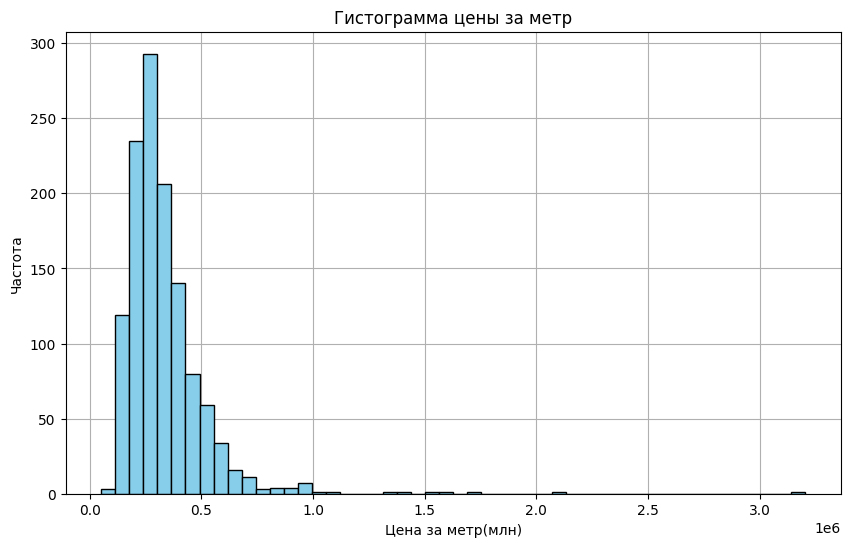

In [290]:
plt.figure(figsize=(10, 6))
df['Цена за метр'].hist(bins=50, color='skyblue', edgecolor='black')
axis = plt.gca()
axis.set_axisbelow(True)
plt.xlabel('Цена за метр(млн)')
plt.ylabel('Частота')
plt.title('Гистограмма цены за метр')
plt.show()

График показывает нам, что мода цены за метр примерно равно 700 тыс.рыблей. Самое большое количество значений находится в диапазоне 200 тыс – 1 млн рублей, но в данной выборке существуют выбросы

**Гистограмма распределения времени до метро**

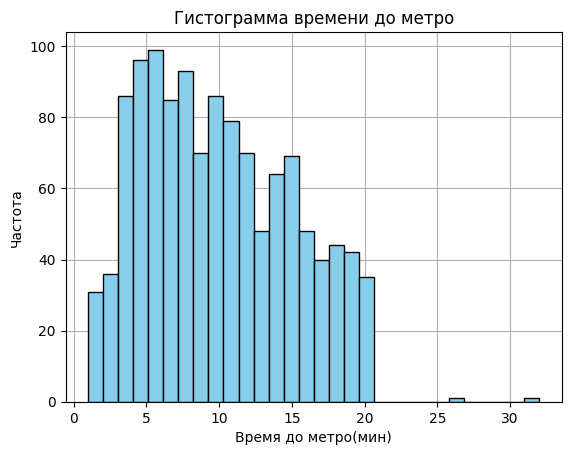

In [291]:
df['Время до метро(мин)'].hist(bins=30, color='skyblue', edgecolor='black')
axis = plt.gca()
axis.set_axisbelow(True)
plt.xlabel('Время до метро(мин)')
plt.ylabel('Частота')
plt.title('Гистограмма времени до метро')
plt.show()

График показывает нам, что в нашей выборке почти все квартиры находятся в пределах 20 минут пешей доступности от метро (мода равна 6 минутам). В выборке также есть выбросы, а именно некоторые квартиры находятся в более 25 минутах от метро.

**Зависимость цены от времени до метро**

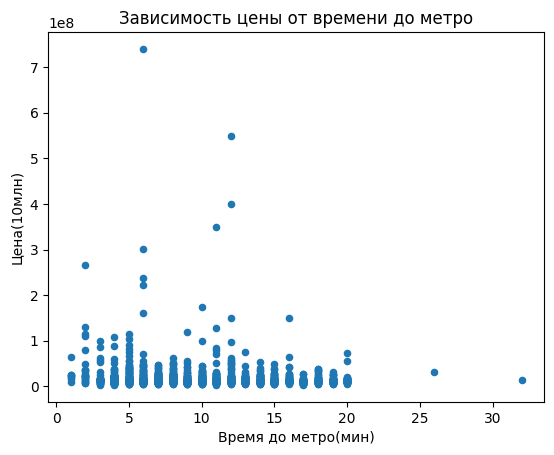

In [292]:
df.plot(x='Время до метро(мин)', y='Цена', kind='scatter')
plt.xlabel('Время до метро(мин)')
plt.ylabel('Цена(10млн)')
plt.title('Зависимость цены от времени до метро')
plt.show()

Мы обнаружили выбросы в "Цена за метр", это значения более 2млн. за метр
Похожая ситуация и с "Цена", наблюдаются выбросы при цене от 220млн за квартиру
Удостоверимся в наших высказывания и удалим выбросы

In [293]:
df['Цена'].sort_values().tail(20)

367     103438700
142     108737200
592     110000000
680     113999999
1002    115000000
120     120000000
552     127300000
1003    130000000
643     150000000
344     150000000
927     160000000
1226    175000000
1084    222000000
759     237044000
851     267000000
758     301200000
638     350000000
795     400000000
511     550000000
255     740000000
Name: Цена, dtype: int32

Действительно, последнии 8 значений существенно выбиваются из общей выборки, удалим их

In [294]:
df['Цена за метр'].sort_values().tail(10)

773      994898
927     1056106
1031    1075000
758     1372835
759     1377362
795     1556420
1084    1574468
638     1750000
511     2075472
851     3205282
Name: Цена за метр, dtype: int32

Уже замеченные выбросы, которые начинаются от 2млн за метр.

In [295]:
df['Время до метро(мин)'].sort_values().tail(10)

449     20
800     20
798     20
501     20
540     20
42      20
889     20
398     20
145     26
1018    32
Name: Время до метро(мин), dtype: int32

In [296]:
df.drop(df[df['Цена'] >= 220000000]['Цена'].index, inplace = True)
df.drop(df[df['Цена за метр'] > 2000000]['Цена за метр'].index, inplace = True)
df.drop(df[df['Время до метро(мин)'] >= 26]['Время до метро(мин)'].index, inplace = True)

**Чтобы увидеть более подробную картину зависимости отберем квартиры до 60млн.**

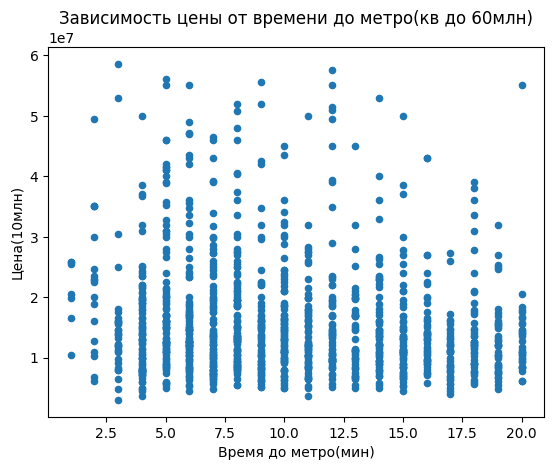

In [297]:
data = {'X' : df['Цена'][(df[df['Цена'] < 60000000].index)],
'Y' : df['Время до метро(мин)'][(df[df['Цена'] < 60000000].index)]}
data = pd.DataFrame(data)
data.plot(x='Y', y='X', kind='scatter')
plt.xlabel('Время до метро(мин)')
plt.ylabel('Цена(10млн)')
plt.title('Зависимость цены от времени до метро(кв до 60млн)')
plt.show()

**Зависимость цены за метр от этажа**

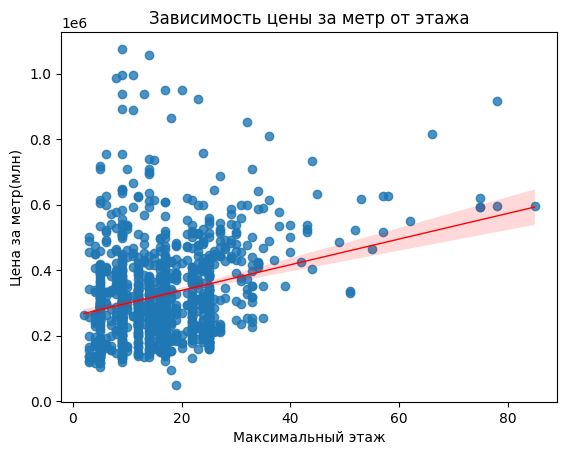

In [298]:
sns.regplot(x="Максимальный этаж", y="Цена за метр", data=df, line_kws={"color": "red", "linewidth": 1})
plt.xlabel('Максимальный этаж')
plt.ylabel('Цена за метр(млн)')
plt.title('Зависимость цены за метр от этажа')
plt.show()

Наблюдается слабая линейная связь между ценой за метр и максимальным этажом. Следовательно, нельзя сделать вывод о том, что при большем максимальном этаже дома, цена за метр квартиры будет больше.

**Построим корреляционную матрицу**

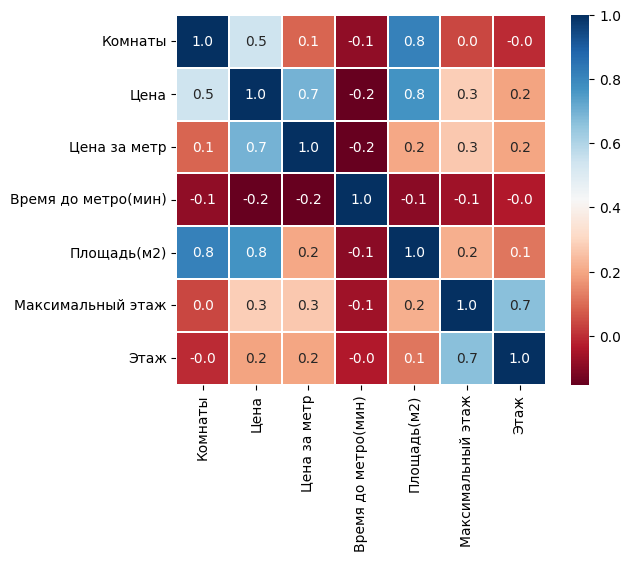

In [299]:
num_columns = df.select_dtypes(include=['int32', 'float32','int64', 'float64']).columns
sns.heatmap(df[num_columns].corr(method='pearson'), 
            square=True, annot=True, fmt=".1f", 
            linewidths=0.1, cmap="RdBu");

Можно заметить, что самую сильную отрицательную корреляцию с ценой имеет время до метро, то есть чем ближе метро, тем выше стоимость квартиры.
Самой большой положительной корреляцией является цена с площадью, что помогает сделать нам вывод о том, что площадь квартиры – одна из самых главных характеристик.

In [300]:
round(df.loc[:, ('Цена', 'Цена за метр', 'Время до метро(мин)', 'Площадь(м2)')].describe(),2).astype(object)

,Цена,Цена за метр,Время до метро(мин),Площадь(м2)
count,1213.0,1213.0,1213.0,1213.0
mean,18302430.2,323990.19,10.18,54.13
std,17066599.28,142871.6,4.89,26.8
min,3000000.0,50000.0,1.0,11.0
25%,9700000.0,228571.0,6.0,37.7
50%,13500000.0,293860.0,10.0,46.0
75%,19900000.0,389855.0,14.0,64.0
max,175000000.0,1075000.0,20.0,218.9


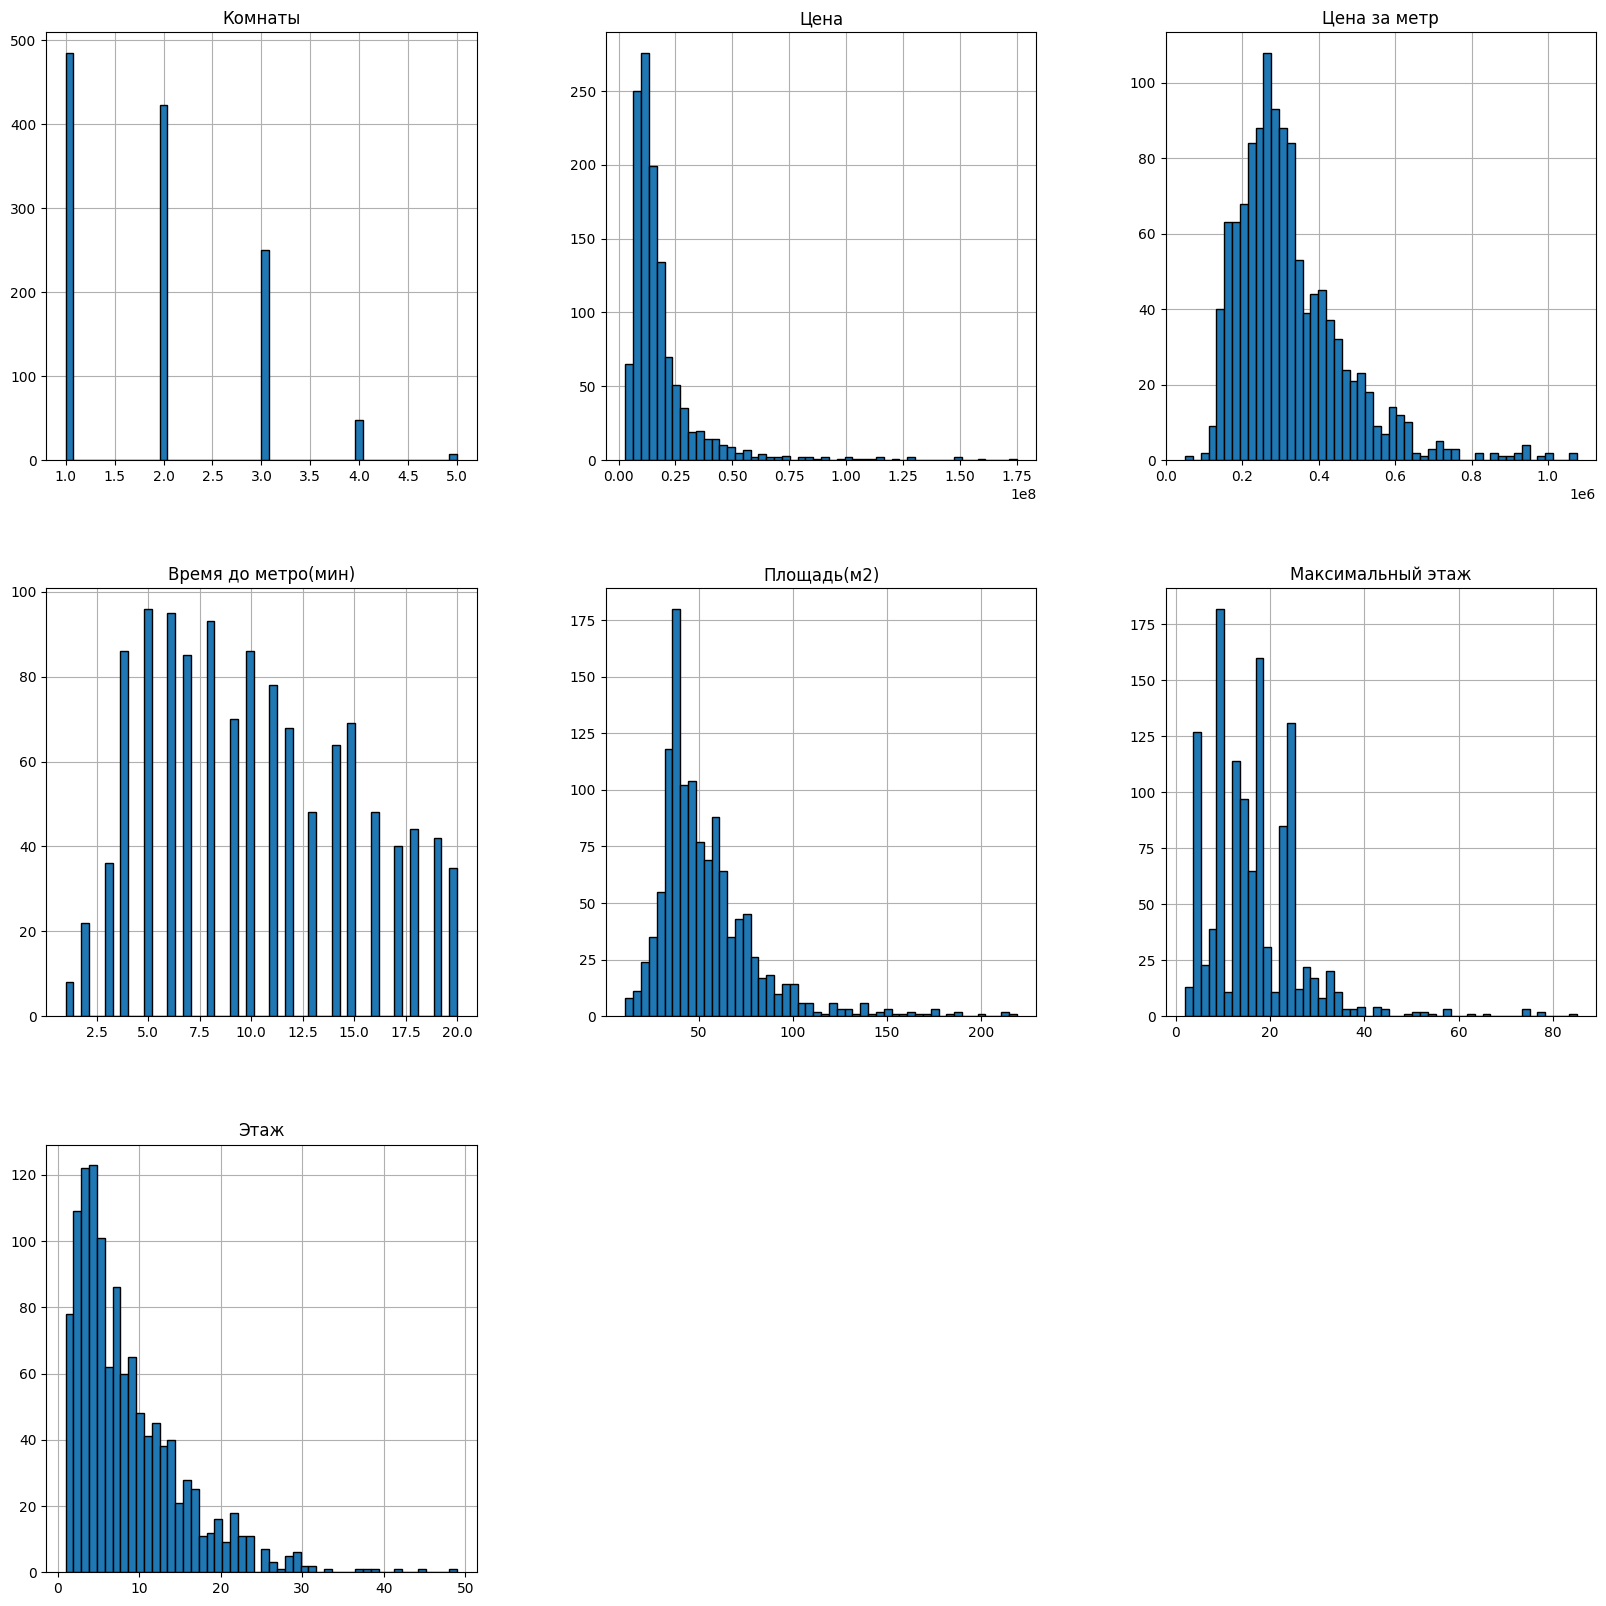

In [301]:
plt.rc('axes', axisbelow=True)
df[colom].hist(bins = 50, figsize = (20, 20), edgecolor='black')
plt.show()

Из данных графиков можно сделать вывод о том, что в нашей выборке больше всего однокомнатных квартир с площадью менее 50 кв.м с максимальным этажом менее 10. У всех графиков не наблюдается конктретного вида рапределения.

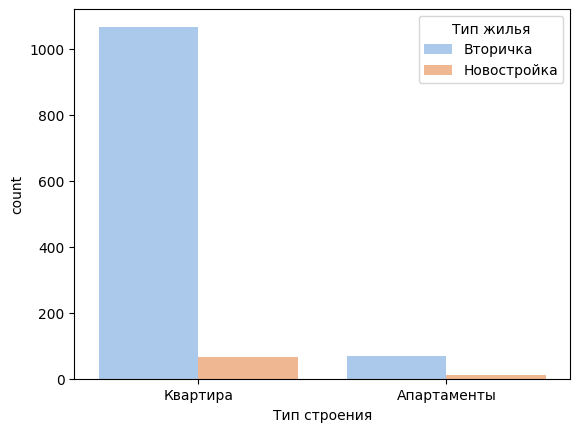

In [302]:
sns.countplot(x='Тип строения', hue = 'Тип жилья', data=df, palette='pastel' )
plt.show()

гипотеза, что однокомнатные на первых этажах

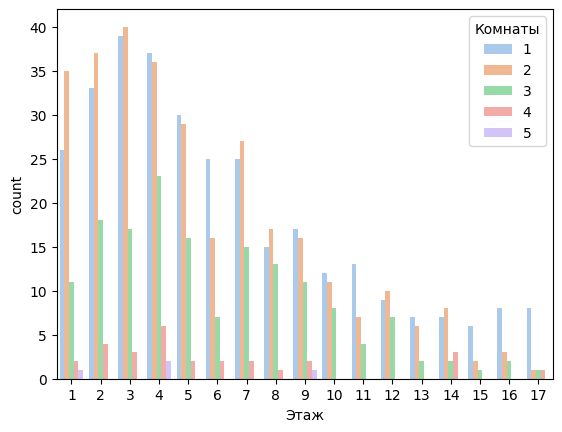

In [303]:
sns.countplot(x='Этаж', hue = 'Комнаты', data=df[df['Максимальный этаж']<=17], palette='pastel' )
plt.show()

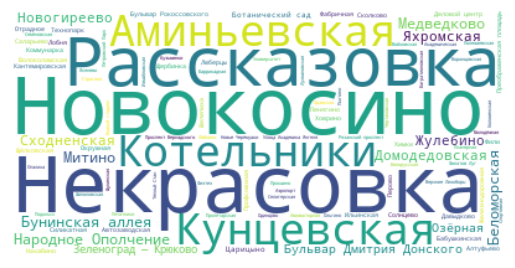

In [304]:
text = df['Метро'].value_counts().to_dict()
wordcloud = WordCloud(background_color = "white", collocations = True).generate_from_frequencies(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off");

В нашей выборке станции Новокосино, Некрасовка и Рассказовка самые популярные. Менее популярные - Кунцевская, Котельники.

# Создание новой переменной

Создадим новую переменную, которая будет отвечать за то находится ближайшее метро к объекту в ЦАО 

In [305]:
cao_metro = ['Рижская', 'Проспект Мира', 'Сухаревская', 'Тургеневская', 'Китай-город',
            'Третьяковская', 'Октябрьская' ,'Белорусская', 'аяковская', 'Тверская', 
            'Театральная', 'Новокузнецкая', 'Павелецкая','Площадь Ильича', 'Марксистская', 
            'Третьяковская' ,'Бауманская', 'Курская','Площадь Революции', 'Арбатская',
            'Смоленская' ,'Красносельская', 'Комсомольская', 'Красные Ворота',
            'Чистые Пруды', 'Лубянка', 'Охотный Ряд', 'Библиотека им Ленина',
            'Парк Культуры', 'Фрунзенская', 'Спортивная', 'Воробьевы Горы', 
            'Кропоткинская' ,'Смоленская', 'Арбатская', 'Александровский Сад', 
            'Проспект Мира', 'Комсомольская', 'Курская', 'Таганская', 'Павелецкая',
            'Добрынинская', 'Октябрьская', 'Парк Культуры', 'Краснопресненская', 'Белорусская',
            'Новослободская' ,'Улица 1905 года', 'Баррикадная', 'Пушкинская', 'Кузнецкий Мост',
            'Китай-город', 'Пролетарская', 'Таганская' ,'Менделеевская', 'Цветной Бульвар',
            'Чеховская', 'Боровицкая', 'Полянка', 'Серпуховская']
def metro(x):
    if x in cao_metro:
        return 1
    else:
        return 0 
df['ЦАО'] = df['Метро'].apply(metro)
df

,Комнаты,Цена,Цена за метр,Метро,Время до метро(мин),Площадь(м2),Максимальный этаж,Этаж,Тип строения,Тип жилья,ЦАО
0,2,27300000,446078,Полежаевская,17,61.2,27,17,Квартира,Вторичка,0
1,3,15400000,215385,Медведково,9,71.5,22,8,Квартира,Новостройка,0
2,2,8050000,180089,Левобережная,9,44.7,5,5,Квартира,Вторичка,0
3,2,19490000,382157,Багратионовская,7,51.0,17,3,Квартира,Вторичка,0
4,2,7000000,132827,Зеленоград — Крюково,6,52.7,9,7,Квартира,Вторичка,0
...,...,...,...,...,...,...,...,...,...,...,...
1222,4,26300000,274817,Кузьминки,14,95.7,23,4,Квартира,Вторичка,0
1223,1,5500000,179739,Фабричная,5,30.6,17,9,Квартира,Вторичка,0
1224,1,6600000,222222,Новокосино,15,29.7,25,16,Квартира,Вторичка,0
1225,2,22350000,397687,Белорусская,9,56.2,12,10,Квартира,Вторичка,1


In [306]:
df['Цена'].corr(df['ЦАО']).round(2)

0.24

Наблюдается незначительна корреляция между ценой и нахождением квартиры в ЦАО.

Создаем переменную, которая будет показывать, сколько стоит комната в квартире

In [307]:
df['Цена за комнату'] = df['Цена']/df['Комнаты']
df['Цена за комнату'] = df['Цена за комнату'].astype(int)
df

,Комнаты,Цена,Цена за метр,Метро,Время до метро(мин),Площадь(м2),Максимальный этаж,Этаж,Тип строения,Тип жилья,ЦАО,Цена за комнату
0,2,27300000,446078,Полежаевская,17,61.2,27,17,Квартира,Вторичка,0,13650000
1,3,15400000,215385,Медведково,9,71.5,22,8,Квартира,Новостройка,0,5133333
2,2,8050000,180089,Левобережная,9,44.7,5,5,Квартира,Вторичка,0,4025000
3,2,19490000,382157,Багратионовская,7,51.0,17,3,Квартира,Вторичка,0,9745000
4,2,7000000,132827,Зеленоград — Крюково,6,52.7,9,7,Квартира,Вторичка,0,3500000
...,...,...,...,...,...,...,...,...,...,...,...,...
1222,4,26300000,274817,Кузьминки,14,95.7,23,4,Квартира,Вторичка,0,6575000
1223,1,5500000,179739,Фабричная,5,30.6,17,9,Квартира,Вторичка,0,5500000
1224,1,6600000,222222,Новокосино,15,29.7,25,16,Квартира,Вторичка,0,6600000
1225,2,22350000,397687,Белорусская,9,56.2,12,10,Квартира,Вторичка,1,11175000


# Проверка гипотез

__№1 Гипотеза: цены на квартиры на низних этажах меньше чем, на высоких__

Предположим, что нижний этаж закнчивается на 5, так как дальше человек хотел бы использоваться лифт, и пешком неудобно подниматься

In [308]:
floor_low = df[df['Этаж'] <= 5]['Цена']
floor_high = df[df['Этаж'] > 5]['Цена']

In [309]:
print((floor_low).size)
print((floor_high).size)

533
680


In [310]:
mean_h = floor_high.mean()
mean_l = floor_low.mean()
var_h = floor_high.var(ddof=1)
var_l = floor_low.var(ddof=1)
n_h = floor_high.size
m_l = floor_low.size
zstat = (mean_h - mean_l)/(var_h/n_h + var_l/m_l)**(1/2)
zcrit = sts.norm.ppf(1-0.05)
if zstat < zcrit: 
    print('Нулевая гипотеза не отвергнута')
else: 
    print('Нулевая гипотеза отвергнута')

Нулевая гипотеза отвергнута


Гипотезы отвергается, следовательно цена квартиры сильно не зависит от этажа, где она находится.

__№2 Гипотеза: цена за комнату в двушке, меньше чем в однушке__

In [311]:
one_room = df[df['Комнаты'] == 1]['Цена за комнату']
two_room = df[df['Комнаты'] == 2]['Цена за комнату']

In [312]:
print((one_room).size)
print((two_room).size)

485
423


In [313]:
mean_о = one_room.mean()
mean_t = two_room.mean()
var_о = one_room.var(ddof=1)
var_t = two_room.var(ddof=1)
n_о = one_room.size
m_t = two_room.size
zstat = (mean_о - mean_t)/(var_о/n_о + var_t/m_t)**(1/2)
zcrit = sts.norm.ppf(1-0.05)
if zstat < zcrit: 
    print('Нулевая гипотеза не отвергнута')
else: 
    print('Нулевая гипотеза отвергнута')

Нулевая гипотеза отвергнута


Гипотеза отвергнута, следовательно, цена за комнату в двушке не меньше, чем в однушке.

__№3 Гипотеза: у квартир в ЦАО время до метро меньше чем в других округах__

In [314]:
cao_metro = df[df['ЦАО'] == 1]['Время до метро(мин)']
other_metro = df[df['ЦАО'] == 0]['Время до метро(мин)']

In [315]:
t_statistic, p_value = sts.ttest_ind(cao_metro ,other_metro , alternative='less')
alpha = 0.05

if p_value < alpha:
    print("Нулевая гипотеза отвергнута")
else:
    print("Нулевая гипотеза не отвергнута")

Нулевая гипотеза отвергнута


Гипотеза отвергнута, следовательно, у квартир в ЦАО не меньше время до метро.

__№4 Гипотеза: цена зависит от максимального этажа__

In [316]:
df_chena=df[['Цена', 'Максимальный этаж']]
p_value = sts.chi2_contingency(df_chena)[1]
if p_value < alpha:
    print('Нулевая гипотеза не отвергнута')
else:
    print('Нулевая гипотеза отвергнута')

Нулевая гипотеза не отвергнута


Гипотеза не отвергнута, значит цена действительно зависит от максимального этажа в доме.

# Машинное обучение

Best alpha = 7.8476


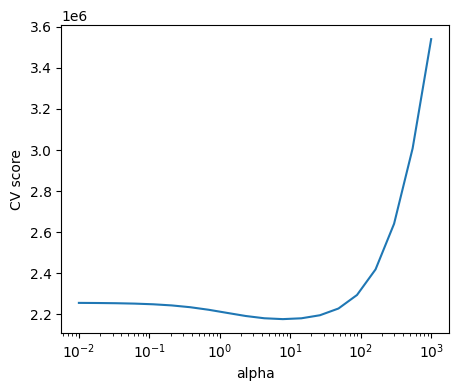

In [317]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(
    Ridge(), [{"alpha": alphas}], 
    scoring="neg_root_mean_squared_error", cv=10
)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.figure(figsize=(5,4))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

# Машинное обучение

In [318]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn. linear_model import RidgeCV
from sklearn. model_selection import RepeatedKFold
from sklearn. linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [319]:
def metrica():
    print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
    print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
    print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
    print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))
    print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
    print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))
    print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))
    print("Test R2 = %.4f" % r2_score(y_test, y_pred))
    print("Train R2 = %.4f" % r2_score(y_train, y_train_pred))

Уберём ценовые выбросы, чтобы машинному обучению было проще обучаться

In [320]:
q1 = df['Цена'].quantile(0.25)
q3 = df['Цена'].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
upp = q3 + 1.5 * iqr

df2 = df[(df['Цена'] <= upp) & (df['Цена'] >= low)]

Сразу сделаем one-hot-encodind, чтобы была возможность работать и с метро

In [321]:
df3 = pd.get_dummies(df2, drop_first = True, dtype = int)
df3

,Комнаты,Цена,Цена за метр,Время до метро(мин),Площадь(м2),Максимальный этаж,Этаж,ЦАО,Цена за комнату,Метро_Автозаводская,...,Метро_Щербинка,Метро_Щукинская,Метро_Щёлковская,Метро_Электрозаводская,Метро_Юго-Западная,Метро_Южная,Метро_Ясенево,Метро_Яхромская,Тип строения_Квартира,Тип жилья_Новостройка
0,2,27300000,446078,17,61.2,27,17,0,13650000,0,...,0,0,0,0,0,0,0,0,1,0
1,3,15400000,215385,9,71.5,22,8,0,5133333,0,...,0,0,0,0,0,0,0,0,1,1
2,2,8050000,180089,9,44.7,5,5,0,4025000,0,...,0,0,0,0,0,0,0,0,1,0
3,2,19490000,382157,7,51.0,17,3,0,9745000,0,...,0,0,0,0,0,0,0,0,1,0
4,2,7000000,132827,6,52.7,9,7,0,3500000,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,1,4850000,303125,4,16.0,5,2,0,4850000,0,...,0,0,0,1,0,0,0,0,0,0
1222,4,26300000,274817,14,95.7,23,4,0,6575000,0,...,0,0,0,0,0,0,0,0,1,0
1223,1,5500000,179739,5,30.6,17,9,0,5500000,0,...,0,0,0,0,0,0,0,0,1,0
1224,1,6600000,222222,15,29.7,25,16,0,6600000,0,...,0,0,0,0,0,0,0,0,1,0


In [322]:
y = df3["Цена"]
X = df3.drop(columns=['Цена','ЦАО'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# отбираем только числовые признаки
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

In [323]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train[numeric_features])
X_test_scaled = scaler_x.transform(X_test[numeric_features])

__Линейная регрессия__

In [335]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

metrica()

Test MAE = 585080363372972544.0000
Train MAE = 1039012.1629
Test MSE = 17689206102910661502498059378571083776.0000
Train MSE = 2448473216712.7847
Test RMSE = 4205853790006336000.0000
Train RMSE = 1564759.7952
Test MAPE = 47387227367.3830
Train MAPE = 0.0789
Test R2 = -386493627075056046702592.0000
Train R2 = 0.9405


In [325]:
polinom_transform = PolynomialFeatures(2, include_bias=False)

X_train_poly = polinom_transform.fit_transform(X_train_scaled)
X_test_poly = polinom_transform.transform(X_test_scaled)

__Lasso регрессия__

In [326]:
model = Lasso(alpha=50)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

metrica()

Test MAE = 263176.3573
Train MAE = 8779.4574
Test MSE = 204429019979.6211
Train MSE = 319746119.1726
Test RMSE = 452138.2753
Train RMSE = 17881.4462
Test MAPE = 0.0216
Train MAPE = 0.0008
Test R2 = 0.9955
Train R2 = 1.0000


Best alpha = 1000.0000


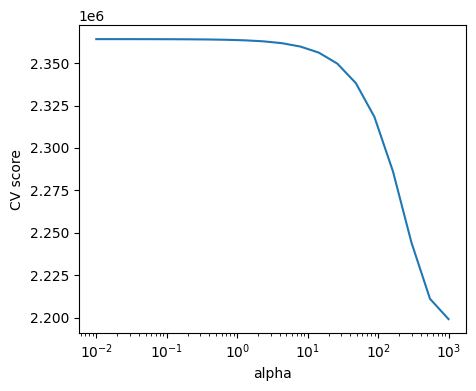

In [327]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(
    Lasso(), [{"alpha": alphas}], 
    scoring="neg_root_mean_squared_error", cv=5
)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)


plt.figure(figsize=(5,4))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

In [328]:
model = Lasso(alpha = 5800)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

metrica()

Test MAE = 18207.7361
Train MAE = 14899.0523
Test MSE = 795534614.1095
Train MSE = 442121263.4417
Test RMSE = 28205.2232
Train RMSE = 21026.6798
Test MAPE = 0.0013
Train MAPE = 0.0011
Test R2 = 1.0000
Train R2 = 1.0000


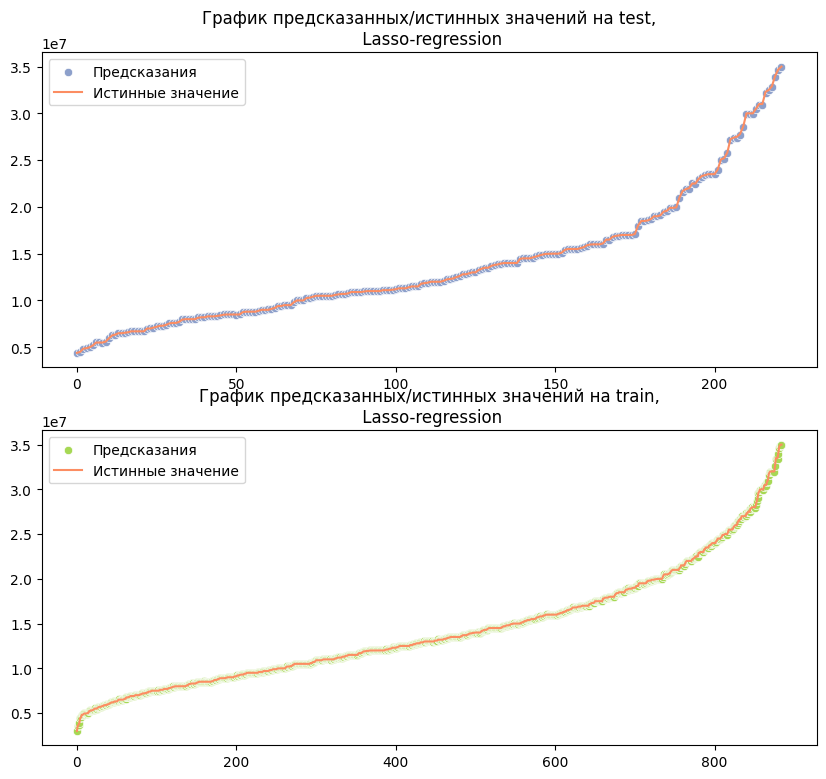

In [329]:
sort_mask_train = np.argsort(y_train.to_numpy())
sort_mask_test = np.argsort(y_test.to_numpy())
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказанных/истинных значений на test,\n Lasso-regression')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[2], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], color = colors[1], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказанных/истинных значений на train,\n Lasso-regression')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[1], label = 'Истинные значение')

plt.legend()
plt.show()

__Ridge регрессия__

In [330]:
model = Ridge(alpha=50)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

metrica()

Test MAE = 2537063.8622
Train MAE = 276321.4564
Test MSE = 14579246407722.5586
Train MSE = 179673686838.0622
Test RMSE = 3818277.9375
Train RMSE = 423879.3305
Test MAPE = 0.2041
Train MAPE = 0.0235
Test R2 = 0.6815
Train R2 = 0.9956


Best alpha = 7.8476


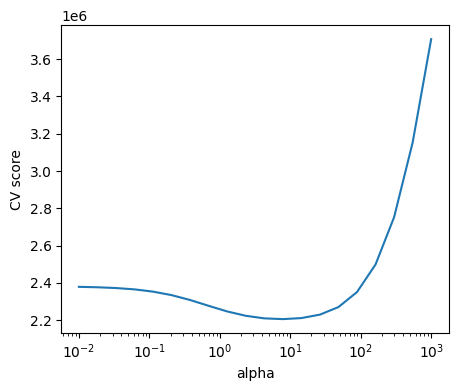

In [331]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(
    Ridge(), [{"alpha": alphas}], 
    scoring="neg_root_mean_squared_error", cv=5
)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)


plt.figure(figsize=(5,4))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

In [332]:
model = Ridge(alpha = best_alpha)

model.fit(X_train_poly, y_train)
y_pred = model.predict(X_test_poly)
y_train_pred = model.predict(X_train_poly)

metrica()

Test MAE = 2316478.0084
Train MAE = 83803.9717
Test MSE = 13718162715746.8926
Train MSE = 21428473395.3645
Test RMSE = 3703803.8171
Train RMSE = 146384.6761
Test MAPE = 0.1926
Train MAPE = 0.0073
Test R2 = 0.7003
Train R2 = 0.9995


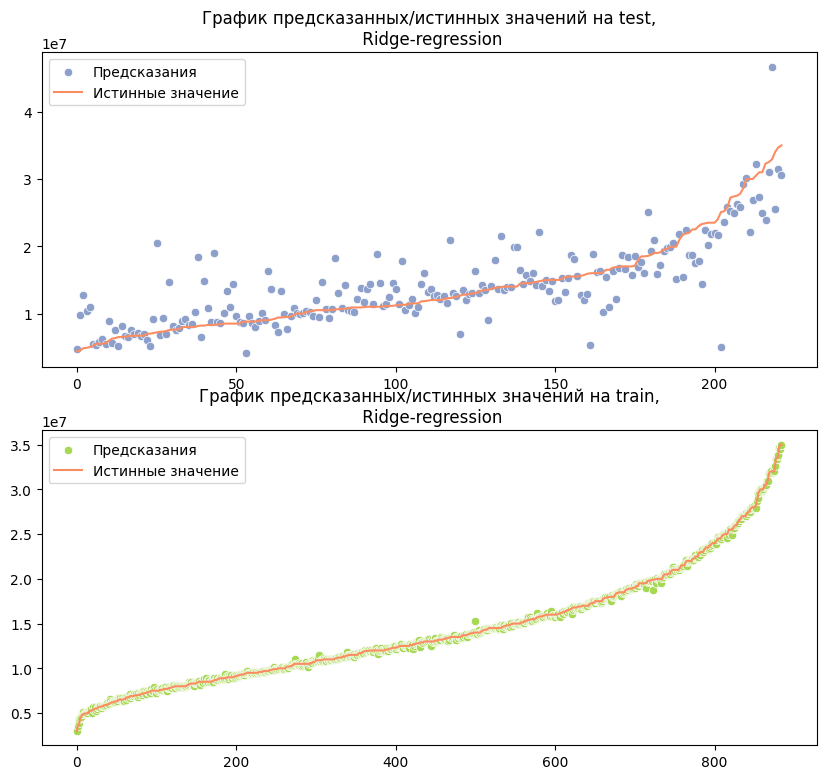

In [333]:
sort_mask_train = np.argsort(y_train.to_numpy())
sort_mask_test = np.argsort(y_test.to_numpy())
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказанных/истинных значений на test,\n Ridge-regression')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[2], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], color = colors[1], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказанных/истинных значений на train,\n Ridge-regression')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[1], label = 'Истинные значение')

plt.legend()
plt.show()